#### 207 Project with different experimentations

##### Reference

In [1]:
# Broken images
from PIL import Image, ImageFile # to avoid broken images
ImageFile.LOAD_TRUNCATED_IMAGES = True # to avoid broken images

# Standard libraries
import numpy as np
import pandas as pd
from glob import glob
from pathlib import Path
from imutils import paths
import os, sys, cv2, time, shutil, random, argparse


# Visualizations
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go # for 3D plots
from plotly.subplots import make_subplots

# pipelines
from sklearn.pipeline import Pipeline

# data preprocessing, cross-validation, accuracies
from sklearn.utils import class_weight, compute_class_weight
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Tensorflow modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.data import AUTOTUNE
from keras.utils import to_categorical
from tensorflow.keras import layers, regularizers
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint, Callback
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D


%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

### Data Preprocessing 

In [2]:
cwd = os.getcwd()
print (cwd)
base_dir = 'datasets/207_Project_final'
DATA_DIR = "/datasets/bone_marrow_cell_dataset/"
LABEL_DIR = "/datasets/"
IMAGE_PATH = (f"{cwd}{DATA_DIR}")
print (IMAGE_PATH)
LABEL_PATH = (f"{cwd}{LABEL_DIR}")

/Users/abc/Desktop/Projects/Data Science/UCB/207/Project
/Users/abc/Desktop/Projects/Data Science/UCB/207/Project/datasets/bone_marrow_cell_dataset/


In [ ]:
# Delete DS_Store files
!find . -name '.DS_Store' -type f -delete

In [3]:
# Create directories for train, validation, and test sets
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    os.mkdir(train_dir)
    os.mkdir(validation_dir)
    os.mkdir(test_dir)

In [4]:
# create class directories in each set of directories
# Split original image dataset to train, validation and test sets
classes = os.listdir(IMAGE_PATH)

# corrupt_image_count = 0  #initialize

for cls in classes:
    class_train_dir = os.path.join(train_dir, cls)
    if not os.path.exists(class_train_dir):
        os.makedirs(class_train_dir)

    class_validation_dir = os.path.join(validation_dir, cls)
    if not os.path.exists(class_validation_dir):
        os.makedirs(class_validation_dir)

    class_test_dir = os.path.join(test_dir, cls)
    if not os.path.exists(class_test_dir):
        os.makedirs(class_test_dir)

    cls_path = os.path.join(IMAGE_PATH, cls)
    # iterating over all folders in the current class directory
    for folderName, subfolders, filenames in os.walk(cls_path):
        imgs = [f for f in filenames if f.endswith('.jpg') or f.endswith('.png') or f.endswith('.bmp') or f.endswith('.jpeg')]
        n_total = len(imgs)
        random.shuffle(imgs)

        train_percentage = 0.7
        val_percentage = 0.2

        n_train = int(train_percentage*n_total)
        n_val = int(val_percentage*n_total)
        n_test = n_total - n_train - n_val

        # indices to split dataset into train, validation, and test sets
        train_idx = 0 + n_train
        val_idx = train_idx + n_val

        # copying images to respective directories
        for img in imgs[0:train_idx]:
            src = os.path.join(folderName, img)
            dst = os.path.join(class_train_dir, img)
            # if os.path.isfile(src) and not os.path.samefile(src, dst): 
            if os.path.isfile(src): # check if files are different:
                shutil.copy(src, dst)

        for img in imgs[train_idx:val_idx]:
            src = os.path.join(folderName,img)
            dst = os.path.join(class_validation_dir, img)
            # if os.path.isfile(src) and not os.path.samefile(src, dst):  # check if files are different:
            if os.path.isfile(src):
                shutil.copy(src,dst)

        for img in imgs[val_idx:]:
            src = os.path.join(folderName,img)
            dst = os.path.join(class_test_dir, img)
            # if os.path.isfile(src) and not os.path.samefile(src, dst):  # check if files are different:
            if os.path.isfile(src):
                shutil.copy(src,dst)

### Generating Data Paths and Loaders

In [5]:
train_image_dir = Path(train_dir)
train_image_count = len(list(train_image_dir.glob('**/*.jpg')))

val_image_dir = Path(validation_dir)
val_image_count = len(list(val_image_dir.glob('**/*.jpg')))

test_image_dir = Path(test_dir)
test_image_count = len(list(test_image_dir.glob('**/*.jpg')))


print(f" Train Image Count: {train_image_count}")
print(f" Validation Image Count: {val_image_count}")
print(f" Test Image Count: {test_image_count}")

# print(f" Validation Image Count", {val_image_count}")
# print (train_image_dir)

 Train Image Count: 119952
 Validation Image Count: 34266
 Test Image Count: 17156


In [6]:
class_names = np.array(sorted([item.name for item in train_image_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)
num_classes = len(class_names)
print(num_classes)

['ABE' 'ART' 'BAS' 'BLA' 'EBO' 'EOS' 'FGC' 'HAC' 'KSC' 'LYI' 'LYT' 'MMZ'
 'MON' 'MYB' 'NGB' 'NGS' 'NIF' 'OTH' 'PEB' 'PLM' 'PMO']
21


# Exploratory Data Analysis

In [7]:
# View an image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  # Setup target directory (we'll view images from here)
  target_folder = target_dir+ "/" +target_class

  # Get a random image path
  random_image = random.sample(os.listdir(target_folder), 1)

  # Read in the image and plot it using matplotlib
  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (250, 250, 3)


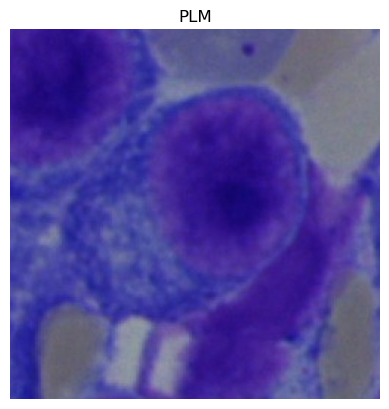

In [8]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_dir,
                        target_class="PLM")

- We can see the shape of the image is 250 x 250 and the 3 is for channels, in this case rgb
#### Now let's see how the images are distributed in our datasets and also visualize the class distributions

In [9]:
# Count number of images in each set
class_counts = {} # create a dictionary to hold the counts

# loop over the directories and count the images in each class and set
for directory in [train_dir, validation_dir, test_dir]:
    for subdirectory in os.listdir(directory):
        class_path = os.path.join(directory, subdirectory)
        count = len(os.listdir(class_path))
        # print(f"{subdirectory}: {count} images in {directory}")
        if subdirectory not in class_counts:
            class_counts[subdirectory] = {}
        class_counts[subdirectory][directory] = count
        
# print out the results in a table
print('\nClass Counts:')
print()
print(f"{'Class':20s} {'Train':<10s} {'Validation':<12s} {'Test':<10s}")
print('-'*55)
for cls, counts in class_counts.items():
    print(f"{cls:20s} {counts[train_dir]:<10d} {counts[validation_dir]:<12d} {counts[test_dir]:<10d}")



Class Counts:

Class                Train      Validation   Test      
-------------------------------------------------------
PLM                  5340       1525         764       
ABE                  5          1            2         
PEB                  1918       548          274       
KSC                  29         8            5         
NGB                  6977       1993         998       
ART                  13741      3926         1963      
HAC                  286        81           42        
MON                  2828       808          404       
PMO                  8395       2398         1201      
MMZ                  2138       611          306       
EBO                  19176      5479         2740      
BLA                  8381       2394         1198      
MYB                  4589       1311         657       
NIF                  2476       707          355       
OTH                  205        58           31        
NGS                  20596      

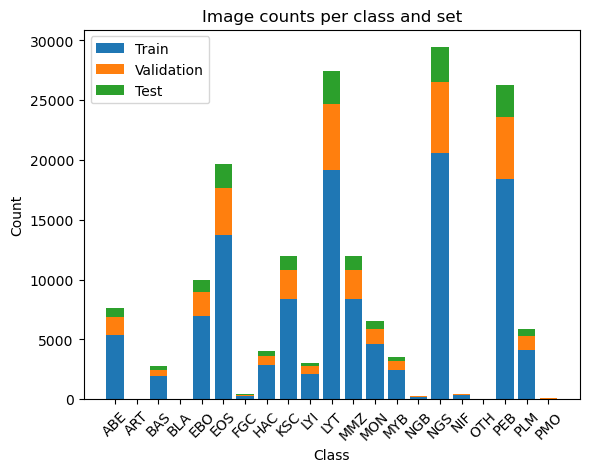

In [10]:
      
# Create lists with the counts for each set
train_counts = [val[train_dir] for val in class_counts.values()]
val_counts = [val[validation_dir] for val in class_counts.values()]
test_counts = [val[test_dir] for val in class_counts.values()]

# Generate x positions for the bars
x_pos = np.arange(len(class_counts))

# Define the colors for each set
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

# Create the bar plot
plt.bar(x_pos, train_counts, color=colors[0], label='Train')
plt.bar(x_pos, val_counts, bottom=train_counts, color=colors[1], label='Validation')
plt.bar(x_pos, test_counts, bottom=np.array(train_counts)+np.array(val_counts), color=colors[2], label='Test')

# Set axis labels and title
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Image counts per class and set")

# Add legend, rotate x-axis labels, and set class names as labels
plt.legend()
plt.xticks(x_pos, class_names, rotation=45)

plt.show()


# Model Architecture and Training

In [11]:
# Set Hyperparameters
batch_size = 32
img_size = (224, 224)
img_height = 224
img_width = 224

In [12]:
# Clear previous model from memory
tf.keras.backend.clear_session()

# Set the seed
tf.random.set_seed(1234)

In [13]:
# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Import data from directories and turn it into batches
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=batch_size, # number of images to process at a time 
                                               target_size=img_size, # convert all images to be 224 x 224
                                               class_mode="categorical", # type of problem we're working on
                                               seed=42)

valid_data = valid_datagen.flow_from_directory(validation_dir,
                                               batch_size=batch_size,
                                               target_size=img_size,
                                               class_mode="categorical",
                                               seed=42)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=batch_size,
                                               target_size=img_size,
                                               class_mode="categorical",
                                               seed=42)

Found 119952 images belonging to 21 classes.
Found 34266 images belonging to 21 classes.
Found 17156 images belonging to 21 classes.


In [ ]:
# class_names = train_data.class_indices
# print(class_names)
# num_classes = len(class_names)
# print(num_classes)
# # print(class_names, num_classes)

#### Let's visualize some random images from the training set

AttributeError: 'numpy.ndarray' object has no attribute 'imshow'

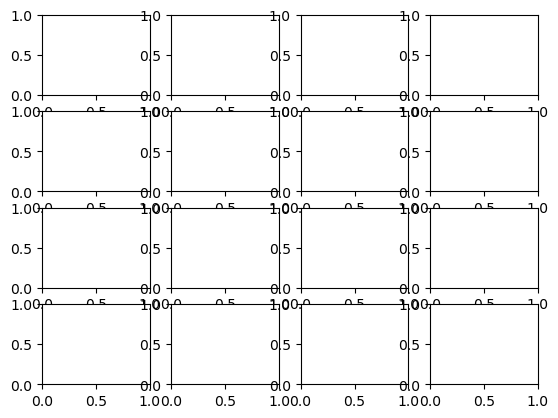

In [22]:
# Define a function to plot a grid of images
def plot_images(images):
    # Get the number of rows and columns for our grid
    num_rows = int(np.ceil(np.sqrt(len(images))))
    num_cols = int(np.ceil(len(images) / num_rows))

    # Create a new figure with the appropriate size
    fig, axs = plt.subplots(num_rows, num_cols)

    # Flatten the axis array if we only have one row or column
    if num_rows == 1:
        axs = np.ravel([axs])
    elif num_cols == 1:
        axs = np.ravel([axs])

    # Loop through the images and plot them
    for i, image in enumerate(images):
        ax = axs[i]
        ax.imshow(image.astype(np.uint8)) # Convert the image to uint8 before plotting
        ax.set_xticks([])
        ax.set_yticks([])

    # Hide any extra axes
    for i in range(len(images), len(axs)):
        axs[i].axis("off")

    # Set the title
    fig.suptitle("Random Images from Train Generator")

# Get a batch of images from the generator
batch = train_data.next()

# Plot a random subset of the images
random_indices = np.random.choice(len(batch[0]), size=16, replace=False)
images = batch[0][random_indices]

plot_images(images)

plt.show()

#### Baseline Model

In [49]:
# Clear previous model from memory
tf.keras.backend.clear_session()

In [50]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_loss` score has improved.
        # The saved model name will include the current epoch.
        filepath= base_dir +"/" +"checkpoints/" "mymodel_{epoch}",
        save_best_only=True,  # Only save a model if `val_loss` has improved.
        monitor="val_loss",
        verbose=1,
    )
]

In [51]:
# Create a CNN model (same as Tiny VGG - https://poloclub.github.io/cnn-explainer/)
model_1 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=(3,3), # can also be (2, 2)
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=(2, 2), # pool_size can also be (3, 3)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes, activation="softmax") # multiclass classification activation output
])

# Compile the model
model_1.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [52]:
# Fit the model
history_1 = model_1.fit(train_data,
                        epochs=5,
                        steps_per_epoch=len(train_data),
                        validation_data=valid_data,
                        validation_steps=len(valid_data), callbacks=callbacks)

Epoch 1/5


2023-04-11 12:21:22.511524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3748/3749 [============================>.] - ETA: 0s - loss: 1.4657 - categorical_accuracy: 0.5446

2023-04-11 12:23:39.016138: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 1.27829, saving model to datasets/207_Project_final/checkpoints/mymodel_1


INFO:tensorflow:Assets written to: datasets/207_Project_final/checkpoints/mymodel_1/assets


INFO:tensorflow:Assets written to: datasets/207_Project_final/checkpoints/mymodel_1/assets


3749/3749 [==============================] - 175s 47ms/step - loss: 1.4656 - categorical_accuracy: 0.5446 - val_loss: 1.2783 - val_categorical_accuracy: 0.6073
Epoch 2/5
3748/3749 [============================>.] - ETA: 0s - loss: 1.1598 - categorical_accuracy: 0.6385
Epoch 2: val_loss improved from 1.27829 to 1.19552, saving model to datasets/207_Project_final/checkpoints/mymodel_2


INFO:tensorflow:Assets written to: datasets/207_Project_final/checkpoints/mymodel_2/assets


INFO:tensorflow:Assets written to: datasets/207_Project_final/checkpoints/mymodel_2/assets


3749/3749 [==============================] - 174s 46ms/step - loss: 1.1597 - categorical_accuracy: 0.6385 - val_loss: 1.1955 - val_categorical_accuracy: 0.6266
Epoch 3/5
3749/3749 [==============================] - ETA: 0s - loss: 1.0258 - categorical_accuracy: 0.6766
Epoch 3: val_loss improved from 1.19552 to 1.18214, saving model to datasets/207_Project_final/checkpoints/mymodel_3


INFO:tensorflow:Assets written to: datasets/207_Project_final/checkpoints/mymodel_3/assets


INFO:tensorflow:Assets written to: datasets/207_Project_final/checkpoints/mymodel_3/assets


3749/3749 [==============================] - 177s 47ms/step - loss: 1.0258 - categorical_accuracy: 0.6766 - val_loss: 1.1821 - val_categorical_accuracy: 0.6355
Epoch 4/5
3748/3749 [============================>.] - ETA: 0s - loss: 0.9042 - categorical_accuracy: 0.7107
Epoch 4: val_loss did not improve from 1.18214
3749/3749 [==============================] - 175s 47ms/step - loss: 0.9041 - categorical_accuracy: 0.7107 - val_loss: 1.3019 - val_categorical_accuracy: 0.6190
Epoch 5/5
3748/3749 [============================>.] - ETA: 0s - loss: 0.7847 - categorical_accuracy: 0.7473
Epoch 5: val_loss did not improve from 1.18214
3749/3749 [==============================] - 175s 47ms/step - loss: 0.7846 - categorical_accuracy: 0.7474 - val_loss: 1.3329 - val_categorical_accuracy: 0.6230


In [53]:
history_df = pd.DataFrame(history_1.history)
display(history_df)

,loss,categorical_accuracy,val_loss,val_categorical_accuracy
0,1.465608,0.544643,1.278286,0.607278
1,1.159718,0.638514,1.195520,0.626598
2,1.025762,0.676612,1.182137,0.635528
3,0.904119,0.710693,1.301883,0.618981
4,0.784603,0.747374,1.332864,0.622979


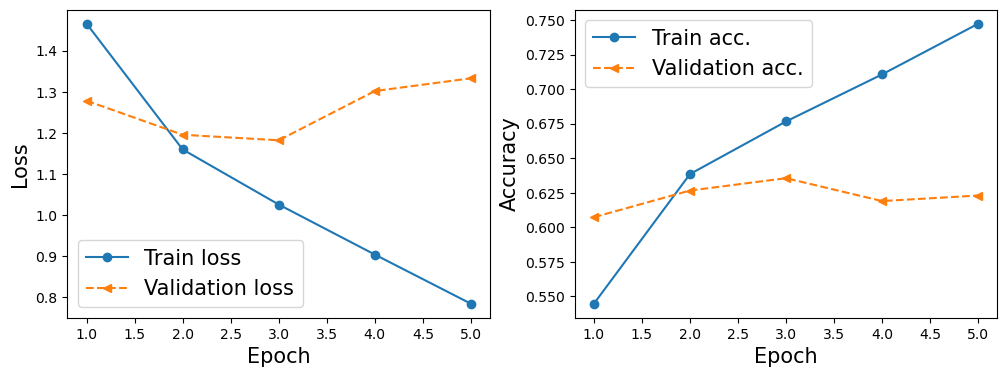

In [54]:
hist_1 = history_1.history
x_arr = np.arange(len(hist_1['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_1['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist_1['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_1['categorical_accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist_1['val_categorical_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

#### Let's Evaluate our model's performance

In [55]:
model_1.evaluate(test_data)

537/537 [==============================] - 19s 36ms/step - loss: 1.3516 - categorical_accuracy: 0.6176


[1.3515969514846802, 0.6176264882087708]

- Our baseline mode's train accuracy is ~74% and val accuracy 62%
- The baseline model's accuracy on test data is ~61%
- Let's see how good the model performs with predictions 

#### Predictions made by the baseline model

In [57]:
# Create a function to import an image and resize it to be able to be used with our model for predictions
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor
  and reshapes it to (img_shape, img_shape, colour_channel).
  """
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels 
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = [img_shape, img_shape])

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img


# Function to work with multi-class
def pred_and_plot(model, filename, class_names):
  """
  Imports an image located at filename, makes a prediction on it with
  a trained model and plots the image with the predicted class as the title.
  """
  # Import the target image and preprocess it
  img = load_and_prep_image(filename)

  # Make a prediction
  pred = model.predict(tf.expand_dims(img, axis=0))

  # Get the predicted class
  if len(pred[0]) > 1: # check for multi-class
    pred_class = class_names[pred.argmax()] # if more than one output, take the max
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])] # if only one output, round

  # Plot the image and predicted class
  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}")
  plt.axis(False);

1/1 [==============================] - 0s 57ms/step


2023-04-11 12:37:10.223102: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


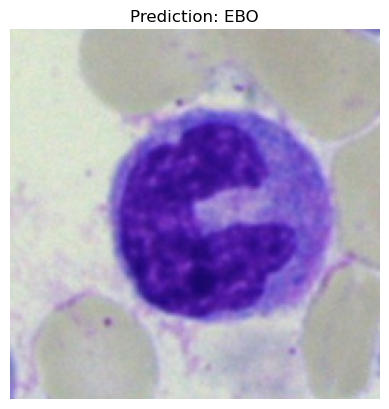

In [58]:
pred_and_plot(model=model_1, 
              filename="/Users/abc/Desktop/Projects/Data Science/UCB/207/Project/datasets/testimg3_mon.jpg", 
              class_names=class_names)

In [59]:
img = load_and_prep_image("/Users/abc/Desktop/Projects/Data Science/UCB/207/Project/datasets/testimg1_abe.jpeg")
img
print(f"Shape before: {img.shape}")

img_exp = tf.expand_dims(img, axis=0)
print(f"Shape After: {img_exp.shape}")
pred = model_1.predict(img_exp)
# pred = model_1.predict(tf.expand_dims(img, axis=0))
pred

Shape before: (224, 224, 3)
Shape After: (1, 224, 224, 3)
1/1 [==============================] - 0s 10ms/step


array([[9.2176847e-18, 1.1049570e-04, 9.8045393e-07, 2.9576826e-03,
        1.3836584e-03, 7.2346437e-03, 4.2786351e-17, 2.4573010e-08,
        0.0000000e+00, 4.2691118e-14, 1.4849373e-03, 1.0499459e-03,
        2.8827842e-02, 5.7762533e-02, 1.2713072e-05, 2.8646355e-08,
        1.3675592e-03, 6.1077588e-07, 6.8555587e-06, 1.8291233e-02,
        8.7950826e-01]], dtype=float32)

In [60]:
pred_class = class_names[int(tf.round(pred)[0][0])]
pred_class

'ABE'

In [ ]:
# test_predictions = np.argmax(model_1.predict(img), axis=-1)
# print(test_predictions)

In [37]:
img2 = load_and_prep_image("/Users/abc/Desktop/Projects/Data Science/UCB/207/Project/datasets/testimg2_plm.jpg")

img_exp2 = tf.expand_dims(img2, axis=0)
pred2 = model_1.predict(img_exp2)
# pred = model_1.predict(tf.expand_dims(img, axis=0))
pred2

1/1 [==============================] - 0s 11ms/step


array([[6.6047483e-20, 1.0720488e-03, 9.1440660e-07, 5.1828139e-02,
        2.1287243e-01, 4.6595618e-05, 1.5486949e-12, 3.0134297e-05,
        5.0864246e-32, 1.8417588e-10, 2.3776630e-02, 7.4107043e-04,
        6.2725483e-03, 2.5576258e-01, 4.9171480e-03, 2.1153582e-04,
        5.6164641e-05, 1.9979173e-07, 3.4784884e-04, 4.3802774e-01,
        4.0362701e-03]], dtype=float32)

In [38]:
pred_class2 = class_names[int(tf.round(pred2)[0][0])]
pred_class2

'ABE'

- All single predictions are class 'ABE', something isn't right. Obviously our model's predictions are not correct. We'd try to correct class imbalance and retrain the model. 

1/1 [==============================] - 0s 10ms/step


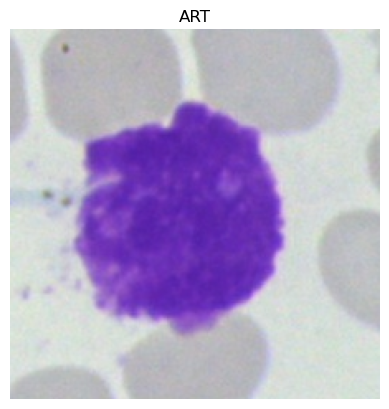

In [40]:
# Load in and preprocess our custom image
img4 = load_and_prep_image("/Users/abc/Desktop/Projects/Data Science/UCB/207/Project/datasets/testimg6_ksc.jpg")

# Make a prediction
pred4 = model_1.predict(tf.expand_dims(img4, axis=0))

# Match the prediction class to the highest prediction probability
pred_class4 = class_names[pred4.argmax()]
plt.imshow(img4)
plt.title(pred_class4)
plt.axis(False);

In [41]:
img6 = load_and_prep_image("/Users/abc/Desktop/Projects/Data Science/UCB/207/Project/datasets/testimg6_ksc.jpg")

pred6 = model_1.predict(tf.expand_dims(img6, axis=0))
# pred = model_1.predict(tf.expand_dims(img, axis=0))
pred6

1/1 [==============================] - 0s 9ms/step


array([[1.7521283e-11, 9.7989172e-01, 5.1983559e-05, 1.2857395e-02,
        8.9773204e-07, 1.2732634e-03, 1.5879663e-05, 1.3685881e-04,
        2.2117129e-05, 3.3705671e-06, 2.0628725e-03, 1.6815902e-04,
        5.6872872e-04, 1.5146275e-04, 1.4685497e-04, 3.6554044e-05,
        2.2382790e-03, 8.0542241e-06, 1.0323022e-06, 1.5207325e-04,
        2.1234216e-04]], dtype=float32)

In [42]:
class_names[pred6.argmax()]

'ART'

### Confusion Matrix

537/537 [==============================] - 18s 34ms/step


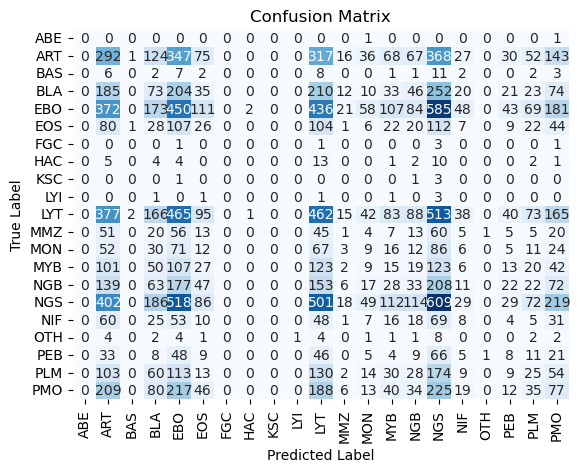

In [62]:
# Get the true labels and predicted labels from the model
y_true = test_data.labels
y_pred = model_1.predict(test_data)

# Convert the predicted probabilities to class labels
y_pred_labels = np.argmax(y_pred, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred_labels)

# Define class names
class_names = test_data.class_indices.keys()

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, cmap="Blues", annot=True, xticklabels=class_names, yticklabels=class_names, cbar=False, fmt='.3g')

# Set plot labels
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

plt.show()


## Data Augmentation for Model_2

In [64]:
# Clear previous model from memory
tf.keras.backend.clear_session()

In [65]:
# Preprocess data (get all of the pixel values between 1 and 0, also called scaling/normalization)
def data_augmentation(batch_size = 32):
    train_datagen_aug = ImageDataGenerator(
            rescale=1/255.,
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest',
            validation_split=0.2
        )
    test_datagen = ImageDataGenerator(rescale=1./255)



    # Import data from directories and turn it into batches
    train_data_aug = train_datagen_aug.flow_from_directory(train_dir,
                                                batch_size=batch_size, # number of images to process at a time 
                                                target_size=img_size, # convert all images to be 224 x 224
                                                class_mode="categorical", # type of problem we're working on
                                                shuffle = True,
                                                seed=42)

    val_data_aug = train_datagen_aug.flow_from_directory(validation_dir,
                                                batch_size=batch_size,
                                                target_size=img_size,
                                                class_mode="categorical",
                                                seed=42)

    test_data_aug = test_datagen.flow_from_directory(test_dir,
                                                batch_size=batch_size,
                                                target_size=img_size,
                                                class_mode="categorical",
                                                seed=42)
    return train_data_aug, val_data_aug, test_data_aug

In [66]:
# Create data augmentation generators
train_aug_gen, val_aug_gen, test_aug_gen = data_augmentation()

Found 119952 images belonging to 21 classes.
Found 34266 images belonging to 21 classes.
Found 17156 images belonging to 21 classes.


In [67]:
# Create a CNN model same as model_1 but augmented data
model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=(3,3), 
                         activation="relu", 
                         input_shape=(224, 224, 3)), # first layer specifies input shape (height, width, colour channels)
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(pool_size=(2,2), # pool_size can also be (2, 2)
                            padding="valid"), # padding can also be 'same'
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.Conv2D(10, 3, activation="relu"), # activation='relu' == tf.keras.layers.Activations(tf.nn.relu)
  tf.keras.layers.MaxPool2D(2, 2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(num_classes, activation="softmax") # multiclass classification activation output
])

# Compile the model
# Compile the model
model_2.compile(loss=keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=[keras.metrics.CategoricalAccuracy()])

model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 10)      280       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 10)      910       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 10)     0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 10)      910       
                                                                 
 conv2d_3 (Conv2D)           (None, 106, 106, 10)      910       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 53, 53, 10)       0         
 2D)                                                    

In [68]:
# Fit the model
history_2 = model_2.fit(train_aug_gen,
                        epochs=5,
                        steps_per_epoch=len(train_aug_gen),
                        validation_data=val_aug_gen,
                        validation_steps=len(val_aug_gen), callbacks=callbacks)

Epoch 1/5


2023-04-11 12:43:12.683710: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


 246/3749 [>.............................] - ETA: 10:38 - loss: 2.3319 - categorical_accuracy: 0.2081

In [ ]:
hist2 = history_2.history
x_arr = np.arange(len(hist2['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist2['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist2['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist2['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist2['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

- With data augmentation, how accuracies have dropped. 
- But seems how model_2 isn't as overfitting as model_1
- Let's evaluate the model on test data and run some predictions. 

In [ ]:
# Evaluate
model_2.evaluate(test_data)

In [ ]:
pred_and_plot(model=model_2, 
              filename="/Users/abc/Desktop/Projects/Data Science/UCB/207/Project/datasets/testimg1_abe.jpeg", 
              class_names=class_names)

- Our model is seemingly predicting PMO classes correctly but not other classes. 
- Let's adjust class imbalance and start doing some transfer learning. 

### Correct for Class Imbalance & Use pre-trained models as base model

In [ ]:
# Clear previous model from memory
tf.keras.backend.clear_session()

In [ ]:
model_3 = tf.keras.Sequential()

# add first convolution layer to the model
model_3.add(tf.keras.layers.Conv2D(
    filters=32,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    name='conv_1',
    activation='relu'))


# add a max pooling layer with pool size (2,2) and strides of 2
# (this will reduce the spatial dimensions by half)
model_3.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2),
    name='pool_1'))


# add second convolutional layer
model_3.add(tf.keras.layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    strides=(1, 1),
    padding='same',
    name='conv_2',
    activation='relu'))

# add second max pooling layer with pool size (2,2) and strides of 2
# (this will further reduce the spatial dimensions by half)
model_3.add(tf.keras.layers.MaxPool2D(
    pool_size=(2, 2), name='pool_2')
)


# add a fully connected layer (need to flatten the output of the previous layers first)
model_3.add(tf.keras.layers.Flatten()) 
model_3.add(tf.keras.layers.Dense(
    units=1024,
    name='fc_1', 
    activation='relu'))

# add dropout layer
model_3.add(tf.keras.layers.Dropout(
    rate=0.5))

# add the last fully connected layer
# this last layer sets the activation function to "None" in order to output the logits 
# note that passing activation = "sigmoid" will return class memembership probabilities but
# in TensorFlow logits are prefered for numerical stability
# set units=1 to get a single output unit (remember it's a binary classification problem)
model_3.add(tf.keras.layers.Dense(
    units=num_classes,
    name='fc_2',
    activation='softmax'))


# build model and print summary
tf.random.set_seed(1)
model_3.build(input_shape=(None, 224, 224, 3))
model_3.summary()

In [ ]:
model_3.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [ ]:
# set random seed to get reproductible results 
# neural network algorithms are stochastic (e.g., due to random weight initialization); setting a random seed helps to get more stable results after each run
# however, best way to deal with randomness is to repeat your experiment many times (30+) and use statistics to summarize the performance of the model
tf.random.set_seed(1234)
np.random.seed(1234)
history = model_3.fit(train_aug_gen,
                    epochs=10, 
                    validation_data=(val_aug_gen))

In [ ]:
hist3 = history.history
x_arr = np.arange(len(hist3['loss'])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist3['loss'], '-o', label='Train loss')
ax.plot(x_arr, hist3['val_loss'], '--<', label='Validation loss')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist3['accuracy'], '-o', label='Train acc.')
ax.plot(x_arr, hist3['val_accuracy'], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)
plt.show()

In [ ]:
# Evaluate
model_3.evaluate(test_data)

- Ok, looks like this model evaluates better on test data. 
- Let's check if it does well on predictions. 

In [ ]:
pred_and_plot(model=model_3, 
              filename="/Users/abc/Desktop/Projects/Data Science/UCB/207/Project/datasets/testimg6_ksc.jpg", 
              class_names=class_names)

In [ ]:
# Confusion Matrix
img6 = load_and_prep_image("/Users/abc/Desktop/Projects/Data Science/UCB/207/Project/datasets/testimg6_ksc.jpg")

pred6 = model_1.predict(tf.expand_dims(img6, axis=0))
# pred = model_1.predict(tf.expand_dims(img, axis=0))
pred6

In [ ]:
# Create a confusion matrix as a 2D array.
confusion_matrix = tf.math.confusion_matrix(Y_test, test_predictions)

# Use a heatmap plot to display it.
ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                 xticklabels=label_names, yticklabels=label_names, cbar=False)

# Add axis labels.
ax.set(xlabel='Predicted Label', ylabel='True Label')
plt.show()

- Our model is still predicting only PMO class correctly. 
- Let's try another model with transfer learning

#### Training with Transfer learning

In [ ]:
# Clear previous model from memory
tf.keras.backend.clear_session()

In [ ]:
class MyCustomCallback(Callback):
    def __init__(self):
        super(MyCustomCallback, self).__init__()

    def on_train_begin(self, logs=None):
        print("Training is started")

    def on_train_end(self, logs=None):
        print("Training is ended")

    def on_epoch_end(self, epoch, logs=None):
        print("Epoch %d - loss: %.4f - accuracy: %.4f" % (epoch, logs['loss'], logs['accuracy']))


In [ ]:
# Increasing batch size and number of epochs
batch_size = 40
epochs = 40

In [ ]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

# create pre-trained model
base_model_1 = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model_4 = Sequential([
    base_model_1,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(num_classes, activation= 'softmax')
])

model_4.compile(Adam(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

checkpoint = ModelCheckpoint(filepath='model_4_checkpoint.h5', save_best_only=True)

model_4.summary()

In [ ]:
tf.random.set_seed(1234)
np.random.seed(1234)
history_4 = model_4.fit(x= train_aug_gen, epochs= epochs, verbose= 0, callbacks= [MyCustomCallback(), checkpoint],
                    validation_data= val_aug_gen, initial_epoch= 0)

### TODO
- Compute Confusion matrix of predictions
- Use weights for training
- Augment underrepresented data in disk 